# NLP With Disaster Tweets

## Problem Description

The NLP With Disaster Tweets Kaggle competition aims to use NLP specific tools to predict disaster tweets. When using Twitter (or any other social media for that matter), people like to dramaticize what they are saying. The goal of this binary classification project is to distinguish tweets that are about real disasters versus tweets that are not.

For example, take the tweet: "On the plus side, LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE". It is clear to you and I that the author of this tweet was speaking metaphorically, however, the distinction for a computer is much harder. The goal is to build a model that can accurately classify disaster related tweets. 

The accuracy metric for this competition is the F1 score. 

## Data Description

The data supplied contains two files, a train.csv and a test.csv. The train.csv file contains the text of a tweet, a keyword from that tweet, the location that tweet was sent from, and a validation column that predicts whether or not the given tweet is about a real disaster (indicated by a 1) or not (indicated by a 0).

The test.csv file contains a tweet and the label for that particular tweet is what needs to be predicted.

## Imports

In [1]:
# standard imports
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# NLP specific imports
import nltk

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# tensorflow specific imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.optimizers import Adam


## Data Imports

In [2]:
# loading the directory to both the train and test data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
# taking a look at 5 sample rows of data
# data cleaning will definitely need to be done
train_df['text'].sample(5)

3265                             Why are you engulfed by low self-image? Take the quiz: http://t.co/I9dSPDKrUK http://t.co/NEp5aZwKNA
2694           Ignition Knock (Detonation) Sensor Connector-Connecto MOTORCRAFT WPT-410 http://t.co/bSmJ2HVgwD http://t.co/bXalnEdy49
6391    #GRupdates Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released --&gt; http://t.co/fqcDPhccg7
5555           major rainstorm happening! I'm gonna lie down and drift away to the storming around me for a little while. bebacksoon.
2502                                                            The Desolate Hope: Part 2: MIRAD: http://t.co/c6lGtOTVSF via @YouTube
Name: text, dtype: object

## Data Cleaning

With our data and necessary packages loaded, we can now begin cleaning the data. To clean the data, I will change all the tweets to lowercase and will remove all puncuation. I will also remove all 'stop words' that have been defined by the nltk package. These are words that do not provide any additional insight, think of words like 'a', 'the', 'is', 'are'. By doing this, it will remove noise from the input to our model and can hopefully result in a higher accuracy. 

Let's see how this works with an example.

In [4]:
# here is a example text before the data is cleaned
train_df['text'][train_df.index == 7146]

7146    Brian Shaw + J.J. Hickson + Kenneth Faried trying to defend LaMarcus Aldridge was A BLOOD VOLCANO http://t.co/20TWGPmM7d
Name: text, dtype: object

In [5]:
# downloading the entire list of english stopwords as determined by nltk.
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/cman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# creating the function preprocess_text that:
# 1. makes all the text lower case
# 2. removes all punctuation and replaces it with a single space
# 3. removes the nltk stop words
def preprocess_text(text):
    text = text.lower()
    text = re.sub (r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [7]:
# applying the preprocessing_text function to both tweet text columns
# in the train and test datasets and placing the text in a new 'cleaned_text' column
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

In [9]:
train_df['cleaned_text'][train_df.index == 7146]

7146    brian shaw j j hickson kenneth faried trying defend lamarcus aldridge blood volcano http co 20twgpmm7d
Name: cleaned_text, dtype: object

## Data Visualization

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_47536/1629585886.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'target', data = train_df, palette = ['salmon', 'purple'])


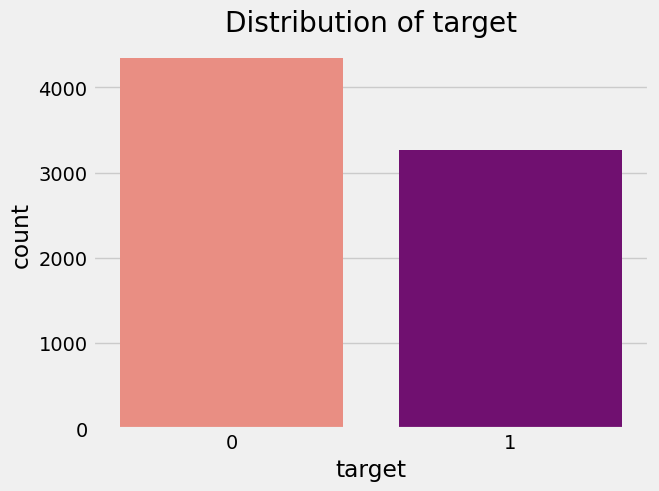

In [10]:
plt.style.use('fivethirtyeight')
sns.countplot(x = 'target', data = train_df, palette = ['salmon', 'purple'])
plt.title('Distribution of target')
plt.show()

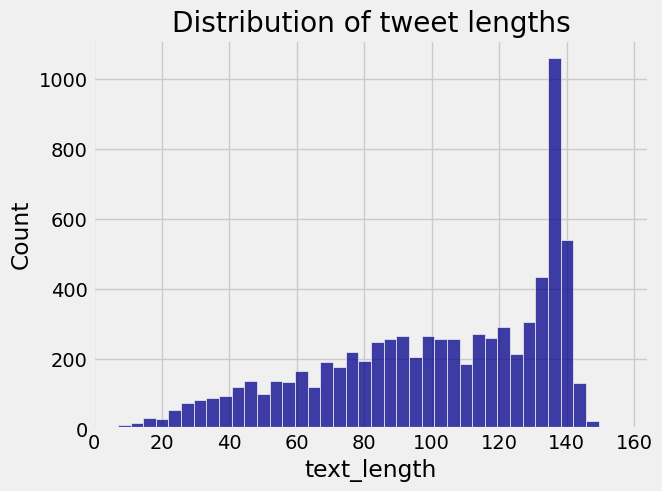

In [11]:
train_df['text_length'] = train_df['text'].apply(len)
sns.histplot(train_df['text_length'], bins = 40, color = 'darkblue')
plt.title('Distribution of tweet lengths')
plt.show()

## Data Preprocessing

In [12]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_df['cleaned_text'])

In [13]:
X_train = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_text'])

In [14]:
max_len = 100
X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
X_test = pad_sequences(X_test, padding = 'post', maxlen = max_len)

In [15]:
y_train = train_df['target'].values

In [16]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size = .15, random_state = 42)

## Model Building

In [17]:
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim = 5000, output_dim = 128)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
dropout_layer = Dropout(0.3)(bi_lstm_layer)
bi_lstm_layer_2 = Bidirectional(LSTM(64))(dropout_layer)
output_layer = Dense(1, activation = 'sigmoid')(bi_lstm_layer_2)

In [18]:
model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = Adam(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

## Model Training

In [19]:
history = model.fit(X_train_split, y_train_split, epochs = 10, batch_size = 16, validation_data = (X_val_split, y_val_split))

Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 67s 162ms/step - accuracy: 0.5753 - loss: 0.6868 - val_accuracy: 0.5701 - val_loss: 0.6760
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 79s 196ms/step - accuracy: 0.5720 - loss: 0.6730 - val_accuracy: 0.5701 - val_loss: 0.6652
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 78s 194ms/step - accuracy: 0.5683 - loss: 0.6617 - val_accuracy: 0.6243 - val_loss: 0.6478
Epoch 4/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 81s 199ms/step - accuracy: 0.6208 - loss: 0.6419 - val_accuracy: 0.6471 - val_loss: 0.6307
Epoch 5/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - accuracy: 0.6507 - loss: 0.6246 - val_accuracy: 0.6497 - val_loss: 0.6238
Epoch 6/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 75s 186ms/step - accuracy: 0.6641 - loss: 0.6094 - val_accuracy: 0.6751 - val_loss: 0.6056
Epoch 7/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 75s 184ms/step - accuracy: 0.7033 - loss: 0.5810 - val_accuracy: 0.7154 - val_loss: 0.5704
Epoch 8/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 74s 183ms/step - accuracy: 0.7563 - loss: 0

## Model Evaluation

In [20]:
val_predictions = model.predict(X_val_split)
val_predictions = (val_predictions > 0.5).astype(int)
val_f1 = f1_score(y_val_split, val_predictions)
print(f'Validation F1 score: {val_f1}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
Validation F1 score: 0.7238095238095238


### Training and Validation Accuracy and Loss

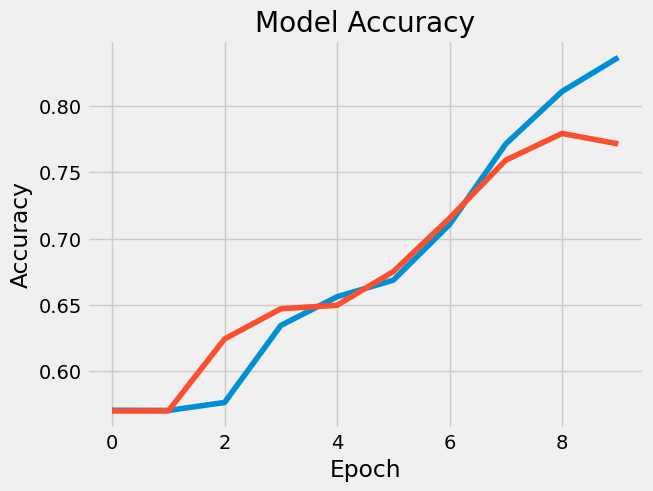

In [21]:
plt.style.use('fivethirtyeight')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.legend(loc = 'lower right')
plt.title('Model Accuracy')
plt.show()

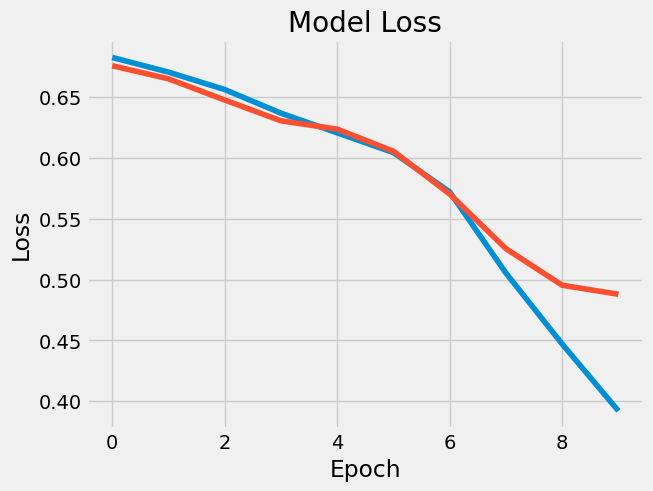

In [22]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.legend(loc = 'upper right')
plt.title('Model Loss')
plt.show()

## Conclusion